[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/rishitdagli/identify-plant-diseases-tensorflow)

In [1]:
!nvidia-smi

Mon Jun  9 13:44:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Identify Plant Diseases

We use the PlantVillage dataset [1] by Hughes et al. consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

* ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples

## Classes

The following 38 classes are availaible in the dataset

- `Apple___Apple_scab`
- `Apple___Black_rot`
- `Apple___Cedar_apple_rust`
- `Apple___healthy`
- `Blueberry___healthy`
- `Cherry_(including_sour)___Powdery_mildew`
- `Cherry_(including_sour)___healthy`
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot`
- `Corn_(maize)___Common_rust_`
- `Corn_(maize)___Northern_Leaf_Blight`
- `Corn_(maize)___healthy', 'Grape___Black_rot`
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)`
- `Grape___healthy`
- `Orange___Haunglongbing_(Citrus_greening)`
- `Peach___Bacterial_spot`
- `Peach___healthy`
- `Pepper,_bell___Bacterial_spot`
- `Pepper,_bell___healthy`
- `Potato___Early_blight`
- `Potato___Late_blight`
- `Potato___healthy`
- `Raspberry___healthy`
- `Soybean___healthy`
- `Squash___Powdery_mildew`
- `Strawberry___Leaf_scorch`
- `Strawberry___healthy`
- `Tomato___Bacterial_spot`
- `Tomato___Late_blight`
- `Tomato___Leaf_Mold`
- `Tomato___Septoria_leaf_spot`
- `Tomato___Spider_mites Two-spotted_spider_mite`
- `Tomato___Target_Spot`
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus`
- `Tomato___Tomato_mosaic_virus`
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [3]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

## Get data

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In TensorFlow this can be done via the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the `tf.keras` model methods that accept data generators as inputs, `fit`, `evaluate` and `predict`.

In [7]:
from google.colab import files
files.upload()  # upload kaggle.json manually


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tommygunner","key":"de84a267930933ac0b0726f682febc1e"}'}

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset -p datasets/vipoooool --unzip


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 96% 2.58G/2.70G [00:07<00:00, 290MB/s]
100% 2.70G/2.70G [00:07<00:00, 366MB/s]


In [27]:
!mkdir -p /content/datasets/gospodapp_clean/train
!mkdir -p /content/datasets/gospodapp_clean/valid

# Move from the 1st path
!mv "/content/datasets/vipoooool/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train" /content/datasets/gospodapp_clean/
!mv "/content/datasets/vipoooool/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid" /content/datasets/gospodapp_clean/


In [28]:
!rm -rf "/content/datasets/vipoooool/New Plant Diseases Dataset(Augmented)"
!rm -rf "/content/datasets/vipoooool/new plant diseases dataset(augmented)"
!rm -rf "/content/datasets/vipoooool/test"


In [29]:
base_dir = "/content/datasets/gospodapp_clean"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "valid")

print("Train:", os.listdir(train_dir)[:5])
print("Valid:", os.listdir(test_dir)[:5])


Train: ['Potato___healthy', 'Pepper,_bell___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___healthy', 'Tomato___Tomato_mosaic_virus']
Valid: ['Potato___healthy', 'Pepper,_bell___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___healthy', 'Tomato___Tomato_mosaic_virus']


We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [30]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

Let's prepare our data. We will use `.flow_from_directory()` to generate batches of image data (and their labels) directly from our images in their respective folders.

In [31]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


## Create a classes index file

We also want to know which class corresponds to which species and disease so we also create a `json` file which shows corresponding labels and class indices.

In [32]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [33]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/content/class_indices.json

## Training

We first get the base MobileNet model without including the top layers since we want to use it for 38 classes and us the pre-trained weights for ImageNet.

In [34]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


We now create a small upstream model on top of the MobileNet using the functional API

In [35]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories),
                          activation="softmax")(x)

model = keras.Model(inputs = inputs,
                    outputs = x,
                    name="LeafDisease_MobileNet")

In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [36]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(),
                       'accuracy'])

In [37]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


150/150 ━━━━━━━━━━━━━━━━━━━━ 73s 436ms/step - accuracy: 0.2699 - categorical_accuracy: 0.2699 - loss: 2.8749 - val_accuracy: 0.8213 - val_categorical_accuracy: 0.8213 - val_loss: 0.7667
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 415ms/step - accuracy: 0.7657 - categorical_accuracy: 0.7657 - loss: 0.8540 - val_accuracy: 0.8769 - val_categorical_accuracy: 0.8769 - val_loss: 0.4736
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 398ms/step - accuracy: 0.8475 - categorical_accuracy: 0.8475 - loss: 0.5533 - val_accuracy: 0.8841 - val_categorical_accuracy: 0.8841 - val_loss: 0.4183
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 388ms/step - accuracy: 0.8645 - categorical_accuracy: 0.8645 - loss: 0.4741 - val_accuracy: 0.8975 - val_categorical_accuracy: 0.8975 - val_loss: 0.3440
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 377ms/step - accuracy: 0.8747 - categorical_accuracy: 0.8747 - loss: 0.4369 - val_accuracy: 0.9237 - val_categorical_accuracy: 0.9237 - val_loss: 0.2812
Epoch 6/25
150/150 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 0.9309 - categorical_accuracy: 0.9309 - loss: 0.2222 - val_accuracy: 0.9316 - val_categorical_accuracy: 0.9316 - val_loss: 0.2056
Epoch 16/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 419ms/step - accuracy: 0.9264 - categorical_accuracy: 0.9264 - loss: 0.2345 - val_accuracy: 0.9406 - val_categorical_accuracy: 0.9406 - val_loss: 0.1761
Epoch 17/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 423ms/step - accuracy: 0.9234 - categorical_accuracy: 0.9234 - loss: 0.2548 - val_accuracy: 0.9447 - val_categorical_accuracy: 0.9447 - val_loss: 0.1622
Epoch 18/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 418ms/step - accuracy: 0.9362 - categorical_accuracy: 0.9362 - loss: 0.2203 - val_accuracy: 0.9447 - val_categorical_accuracy: 0.9447 - val_loss: 0.1641
Epoch 19/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 402ms/step - accuracy: 0.9260 - categorical_accuracy: 0.9260 - loss: 0.2188 - val_accuracy: 0.9428 - val_categorical_accuracy: 0.9428 - val_loss: 0.1710
Epoch 20/25
150/150 ━━

## Review the training process

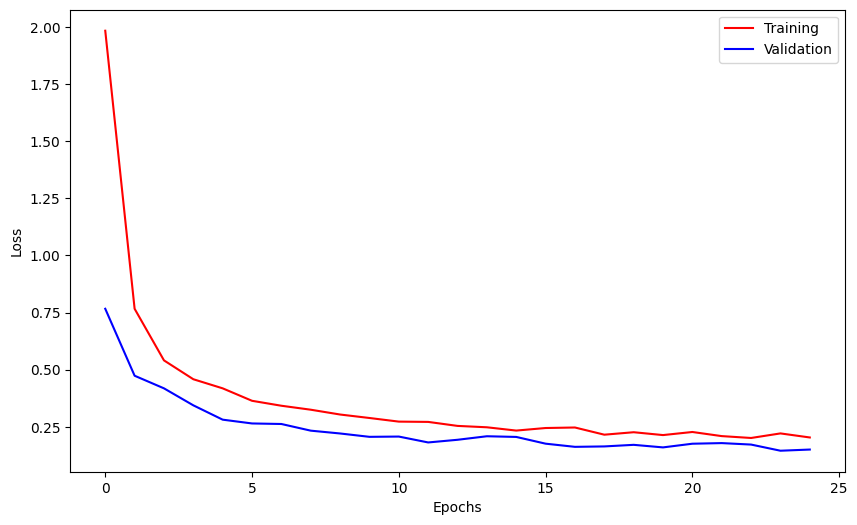

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

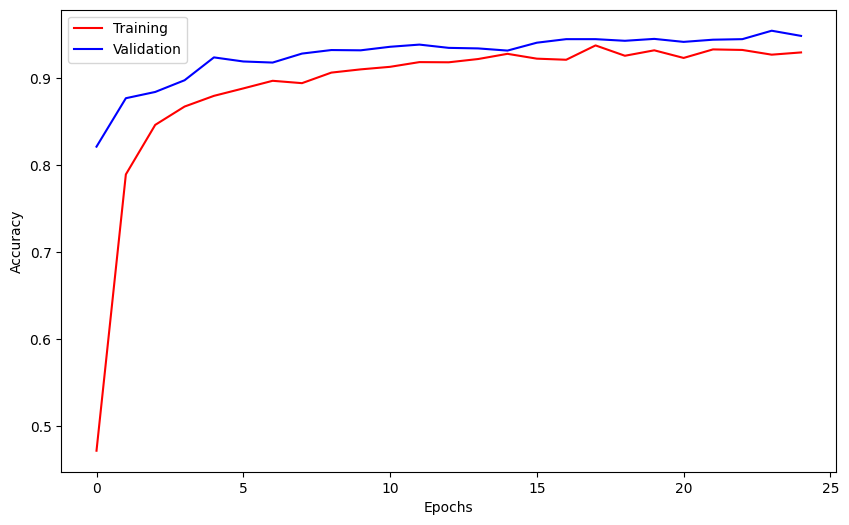

In [39]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Save the model

We finally save the model in the standard TensorFlow 2 SavedModel format.

In [45]:
# Save in modern format (optional, for future editing)
model.save("gospodapp.keras")  # Not required for Android, but nice to have

# Convert to TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Dynamic range quantization
tflite_model = converter.convert()

# Save to .tflite
with open("gospodapp_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Exported gospodapp_model.tflite")


Saved artifact at '/tmp/tmpzpah4f3f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_86')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  132542999423184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890494480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890494864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890392656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890393424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542990647952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890494096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890493328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890495248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132542890495056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325428904

In [46]:
from google.colab import files
files.download("gospodapp_model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>